In [1]:
import os, sys , json
sys.path.append("H:/Mon Drive/LabMembers/Hamid/Eco_Foundation/Eco_Foundation")
from function import plt,Path_manager_local,utils,utils_2,Split_AnnData
from  function.Path_manager_local import *
from  function.utils import *
from  function.utils_2 import *
from  function.Split_AnnData import *
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import scanpy as sc
from torchinfo import summary

from model_n_loss.Vae_v3 import *
from model_n_loss import loss
import importlib
importlib.reload(loss)
from model_n_loss.loss import *

import torchsummary

# from importlib import reload

seed = 42
torch.manual_seed(seed)

## Run on local notebook

In [4]:
# Load TMA data (Scanpy AnnData objects)
tma_data = get_tma_objects()

# Load EcoFoundation objects
eco_data = get_eco_objects()


Loaded: Processed_new_TMA_1_1.h5ad
Loaded: Processed_new_TMA_1_10.h5ad
Loaded: Processed_new_TMA_1_11.h5ad
Loaded: Processed_new_TMA_1_12.h5ad
Loaded: Processed_new_TMA_1_13.h5ad
Loaded: Processed_new_TMA_1_14.h5ad
Loaded: Processed_new_TMA_1_15.h5ad
Loaded: Processed_new_TMA_1_16.h5ad
Loaded: Processed_new_TMA_1_17.h5ad
Loaded: Processed_new_TMA_1_18.h5ad
Loaded: Processed_new_TMA_1_19.h5ad
Loaded: Processed_new_TMA_1_2.h5ad
Loaded: Processed_new_TMA_1_20.h5ad
Loaded: Processed_new_TMA_1_21.h5ad
Loaded: Processed_new_TMA_1_22.h5ad
Loaded: Processed_new_TMA_1_23.h5ad
Loaded: Processed_new_TMA_1_24.h5ad
Loaded: Processed_new_TMA_1_25.h5ad
Loaded: Processed_new_TMA_1_26.h5ad
Loaded: Processed_new_TMA_1_27.h5ad
Loaded: Processed_new_TMA_1_28.h5ad
Loaded: Processed_new_TMA_1_29.h5ad
Loaded: Processed_new_TMA_1_3.h5ad
Loaded: Processed_new_TMA_1_30.h5ad
Loaded: Processed_new_TMA_1_31.h5ad
Loaded: Processed_new_TMA_1_32.h5ad
Loaded: Processed_new_TMA_1_33.h5ad
Loaded: Processed_new_TMA_1_34.

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_num_cells_per_sample(
    TMA_objects,
    sample_label_key=None,
    order_by='num_cells',      # or 'sample', or 'custom'
    ascending=True,           # for 'num_cells' sorting (descending by default)
    custom_order=None
):

    sample_names = []
    num_cells = []

    for i, adata in enumerate(TMA_objects):
        # Derive the sample name
        if sample_label_key is not None and sample_label_key in adata.obs:
            sample_name = str(adata.obs[sample_label_key].iloc[0])
        else:
            sample_name = f"Sample_{i}"
        
        sample_names.append(sample_name)
        num_cells.append(adata.n_obs)  # number of cells in this AnnData
    
    # Make a DataFrame
    df = pd.DataFrame({"Sample": sample_names, "Number of Cells": num_cells})

    # Decide ordering
    if order_by == 'num_cells':
        # Sort by number of cells
        df = df.sort_values(by="Number of Cells", ascending=ascending)
    elif order_by == 'sample':
        # Sort by sample name (alphabetically)
        df = df.sort_values(by="Sample", ascending=True)
    elif order_by == 'custom':
        # Must provide custom_order = ["Sample_A", "Sample_B", ...]
        if not custom_order:
            raise ValueError("Must provide custom_order when order_by='custom'.")
        # Convert the user-provided list into a mapping
        order_map = {name: i for i, name in enumerate(custom_order)}
        # Filter out samples not in the custom_order
        df = df[df["Sample"].isin(order_map.keys())]
        # Sort by the index given in order_map
        df["order_index"] = df["Sample"].map(order_map)
        df = df.sort_values(by="order_index").drop(columns="order_index")
    else:
        raise ValueError(f"Invalid order_by={order_by}. Must be 'num_cells', 'sample', or 'custom'.")

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x="Sample", y="Number of Cells")
    plt.title("Number of Cells per MERFISH Sample / Patient")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


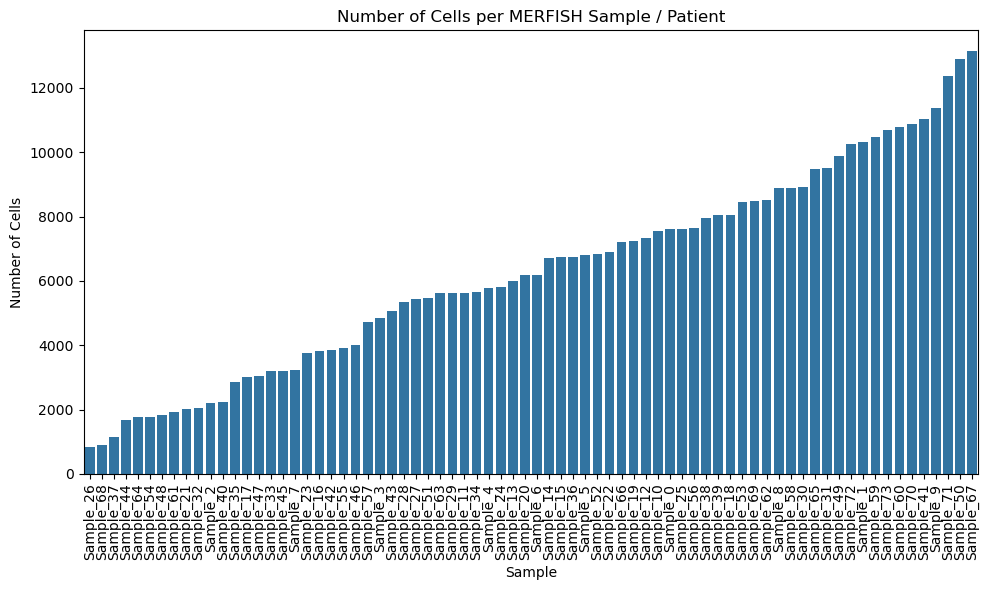

In [10]:
plot_num_cells_per_sample(tma_data, sample_label_key=None)

In [27]:

def plot_library_sizes(TMA_objects, data_key='nCount_RNA'):
    """
    Accumulate library sizes from multiple AnnData objects (MERFISH samples)
    and display them together in a single boxplot or violin plot, sorted by median values.
    
    Parameters
    ----------
    TMA_objects : list of AnnData
        Each AnnData has .obs[data_key] with the library size of each cell.
    data_key : str, optional
        Column name in .obs that stores the library size (default: 'nCount_RNA').
    """
    all_data = []
    
    for i, adata in enumerate(TMA_objects):
        library_size = adata.obs[data_key].values
        
        df = pd.DataFrame({
            'library_size': library_size,
            'sample_id': f'Sample_{i}'
        })
        all_data.append(df)
    
    # Concatenate all sample DataFrames into one
    df_all = pd.concat(all_data, ignore_index=True)
    
    # Calculate median library size for each sample
    medians = df_all.groupby('sample_id')['library_size'].median().sort_values()
    
    # Create order based on sorted medians
    sample_order = medians.index.tolist()
    
    # Create the figure
    plt.figure(figsize=(10, 6))
    
    # Plot with ordered samples
    sns.boxplot(data=df_all, x='sample_id', y='library_size', order=sample_order)
    
    plt.xticks(rotation=90)
    plt.title("Library Size (raw sum of counts per cell) across MERFISH Samples")
    plt.tight_layout()
    plt.show()

In [29]:
tma_data

[AnnData object with n_obs × n_vars = 7616 × 500
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ident', 'celltype', 'leiden'
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'Graph_DF', 'barcode_mapping', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
     obsm: 'X_pca', 'X_umap', 'pca', 'spatial', 'umap'
     varm: 'PCs'
     layers: 'counts', 'norm'
     obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances',
 AnnData object with n_obs × n_vars = 10323 × 500
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ident', 'celltype', 'leiden'
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'Graph_DF', 'barcode_mapping', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
     obsm: 'X_pca', 'X_umap', 'pca', 'spatial', 'umap'
     varm: 'PCs'
     layers: 'counts', 'norm'
     obsp: 'connectivities', 'distances', 'spatial_connectivities'

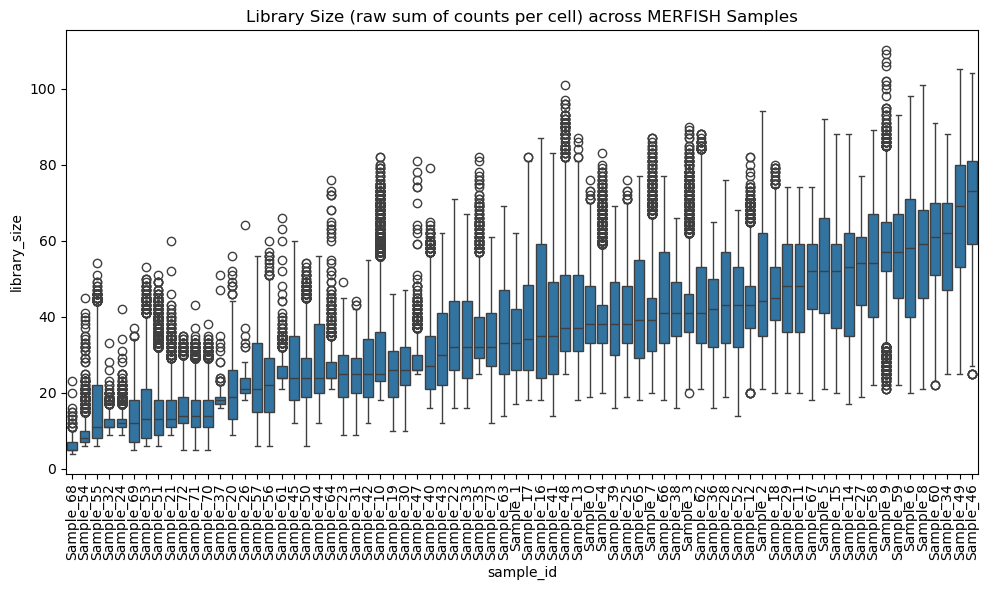

In [28]:
plot_library_sizes (tma_data, data_key='nCount_RNA')


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_celltype_per_sample(
    TMA_objects,
    celltype_key='celltype',
    sample_label_key=None,
    order_by='sample',
    ascending=True,
    custom_order=None,
    as_percent=False,
    stacked=True,
    figsize=(10, 6),
    colormap='tab20'
):
    """
    Plots how many cells of each 'celltype' exist in each sample, as either a
    stacked or grouped bar chart. Also allows ordering the samples in various ways,
    and plotting counts or percentages.

    Parameters
    ----------
    TMA_objects : list[AnnData]
        Each AnnData corresponds to a sample (e.g. patient/object).
        We expect .obs[celltype_key] to exist, labeling cell types for each cell.

    celltype_key : str, optional
        The column in .obs that indicates the cell type (default: 'celltype').

    sample_label_key : str, optional
        If provided, we read adata.obs[sample_label_key][0] as the sample name
        (assuming each sample in TMA_objects has consistent naming in .obs).
        Otherwise we label them "Sample_0", "Sample_1", etc.

    order_by : {'sample', 'num_cells', 'custom'}, optional
        How to order the bars on the x-axis.
        - 'sample'   => alphabetical by sample name
        - 'num_cells'=> total # of cells in that sample (descending/ascending controlled by 'ascending')
        - 'custom'   => use a user-provided list of sample names in custom_order

    ascending : bool, optional
        If order_by='num_cells', ascending=False means largest -> smallest. 
        If order_by='sample', ascending=True sorts sample names alphabetically A->Z (default).
        Not used if order_by='custom'.

    custom_order : list of str, optional
        If order_by='custom', you must provide this list of sample names in the
        exact order you want them displayed. Any sample not in the list is omitted.

    as_percent : bool, optional
        If True, convert counts to row percentages. Each bar sums to 100%.

    stacked : bool, optional
        If True (default), produce a stacked bar chart. If False, produce a grouped (side-by-side) bar chart.

    figsize : tuple, optional
        Figure size passed to matplotlib.

    colormap : str, optional
        Colormap name for the bars.

    Returns
    -------
    None. Displays a bar chart of celltype counts (or percentages) per sample.
    """

    all_data = []

    for i, adata in enumerate(TMA_objects):
        # 1) Determine name for the sample
        if sample_label_key is not None and sample_label_key in adata.obs:
            # If all cells in the adata have the same label, we just take the first
            sample_name = str(adata.obs[sample_label_key].iloc[0])
        else:
            sample_name = f"Sample_{i}"
        
        # 2) Check if celltype_key is in .obs
        if celltype_key not in adata.obs:
            print(f"Warning: '{celltype_key}' not found in adata.obs for {sample_name}. Skipping.")
            continue
        
        # 3) Extract the celltype array
        types = adata.obs[celltype_key].values
        
        # 4) Create a small DataFrame with columns: [celltype, sample_id]
        df = pd.DataFrame({
            'celltype': types,
            'sample_id': sample_name
        })
        all_data.append(df)
    
    # If we ended up with no data, exit
    if not all_data:
        print(f"No data found with '{celltype_key}' across samples. Exiting.")
        return
    
    # 5) Combine all samples into one DataFrame
    df_all = pd.concat(all_data, ignore_index=True)

    # 6) Count number of cells per (sample_id, celltype)
    # => groupby, then pivot
    count_df = df_all.groupby(['sample_id', 'celltype']).size().reset_index(name='count')
    pivot_df = count_df.pivot(index='sample_id', columns='celltype', values='count').fillna(0)

    # 7) Possibly convert counts to percentages
    # Each row => sum of all cell types in that sample
    if as_percent:
        pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

    # 8) Sorting the rows
    # We'll create a 'sort_df' (one row per sample) to figure out the order
    sort_df = pivot_df.copy()
    sort_df['Total'] = pivot_df.sum(axis=1)  # total cells or total% if as_percent

    if order_by == 'sample':
        # Sort by sample name (the index of pivot_df is 'sample_id')
        pivot_df = pivot_df.sort_index(ascending=ascending)
    elif order_by == 'num_cells':
        # Sort by total in ascending or descending
        pivot_df = pivot_df.loc[sort_df.sort_values('Total', ascending=ascending).index]
    elif order_by == 'custom':
        # We need a custom_order list of sample names
        if not custom_order:
            raise ValueError("Must provide custom_order when order_by='custom'.")
        # Filter pivot_df to only the sample IDs in custom_order
        # (in case some are missing or extra)
        pivot_df = pivot_df.loc[pivot_df.index.intersection(custom_order)]
        # Reindex exactly in that order
        pivot_df = pivot_df.reindex(custom_order)
    else:
        raise ValueError("order_by must be 'sample', 'num_cells', or 'custom'")

    # 9) Plot with Pandas .plot(kind='bar'), using stacked or grouped style
    plt.figure(figsize=figsize)
    pivot_df.plot(
        kind='bar',
        stacked=stacked,
        figsize=figsize,
        colormap=colormap
    )
    title_str = f"Cell Type per Sample (celltype_key='{celltype_key}')"
    if as_percent:
        title_str += " [Percent]"
    plt.title(title_str)
    plt.xlabel("Sample")
    plt.ylabel("Number of Cells" if not as_percent else "Percentage of Cells")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


<Figure size 1000x600 with 0 Axes>

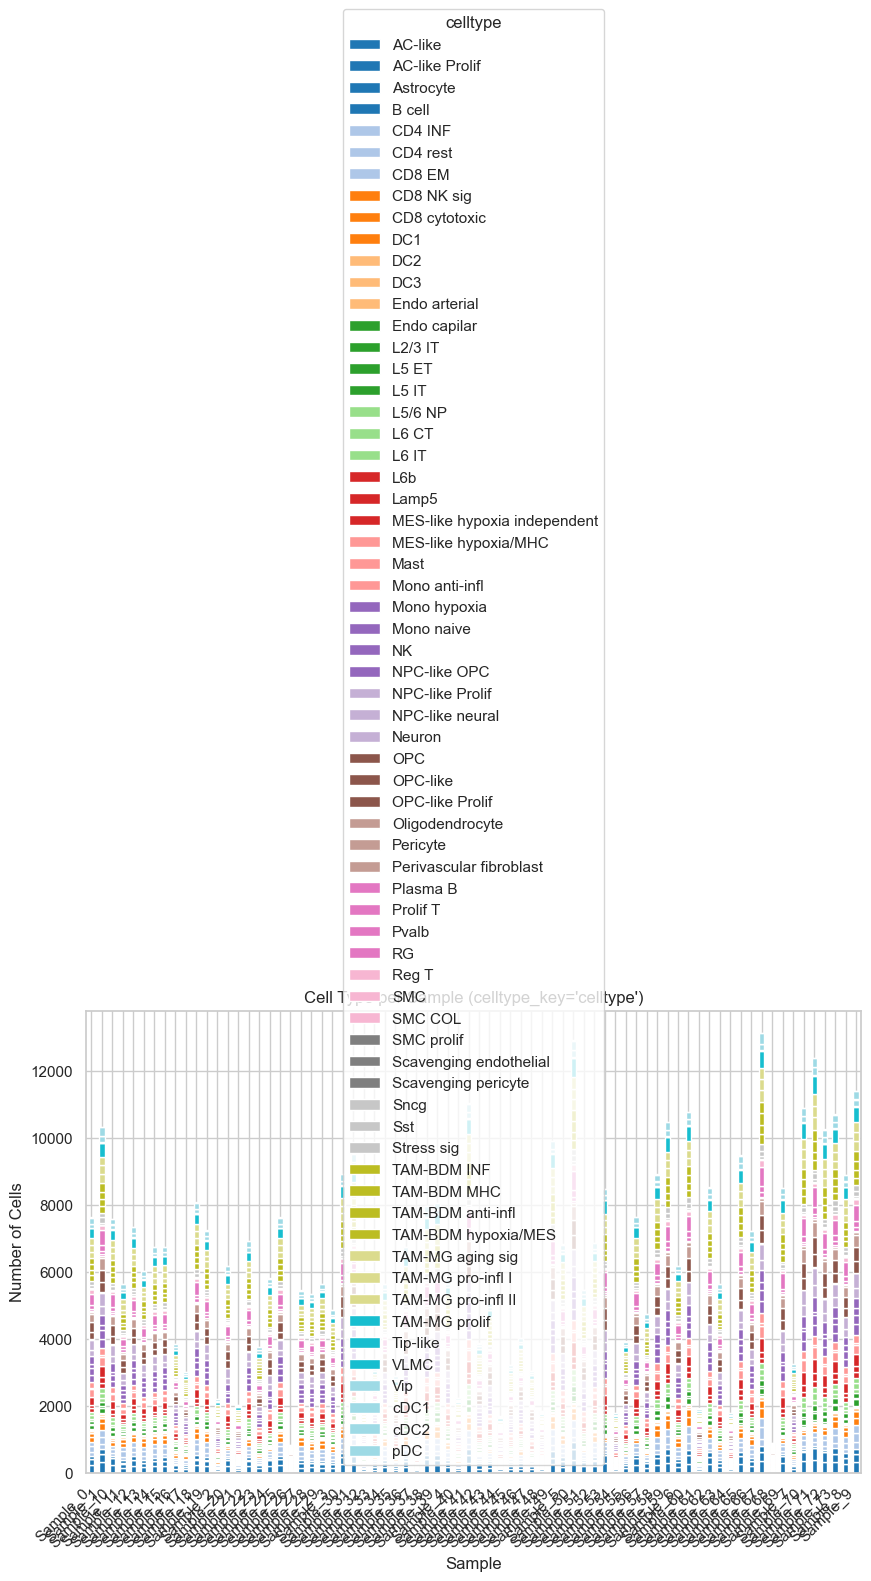

In [33]:

plot_celltype_per_sample(tma_data, celltype_key='celltype', sample_label_key='patient_id')


In [17]:
def summarize_adata_list(TMA_objects, data_key='nCount_RNA'):
    """
    Print a quick summary of each AnnData in TMA_objects.
    """
    print("Summary of MERFISH Datasets:")
    print("===========================")
    for i, adata in enumerate(TMA_objects):
        n_cells, n_genes = adata.n_obs, adata.n_vars
        print(f"\nSample {i}: shape = ({n_cells} cells, {n_genes} genes)")
        
        if data_key in adata.obs:
            min_val = adata.obs[data_key].min()
            median_val = adata.obs[data_key].median()
            max_val = adata.obs[data_key].max()
            print(f"  {data_key}: min={min_val:.1f}, median={median_val:.1f}, max={max_val:.1f}")
        else:
            print(f"  {data_key} not found in adata.obs")

# Usage:


In [18]:

summarize_adata_list(tma_data, data_key='nCount_RNA')


Summary of MERFISH Datasets:

Sample 0: shape = (7616 cells, 500 genes)
  nCount_RNA: min=19.0, median=38.0, max=76.0

Sample 1: shape = (10323 cells, 500 genes)
  nCount_RNA: min=17.0, median=33.0, max=62.0

Sample 2: shape = (2190 cells, 500 genes)
  nCount_RNA: min=21.0, median=44.0, max=94.0

Sample 3: shape = (4842 cells, 500 genes)
  nCount_RNA: min=20.0, median=41.0, max=90.0

Sample 4: shape = (5769 cells, 500 genes)
  nCount_RNA: min=20.0, median=38.0, max=83.0

Sample 5: shape = (6813 cells, 500 genes)
  nCount_RNA: min=21.0, median=52.0, max=92.0

Sample 6: shape = (6172 cells, 500 genes)
  nCount_RNA: min=20.0, median=58.0, max=98.0

Sample 7: shape = (3232 cells, 500 genes)
  nCount_RNA: min=20.0, median=39.0, max=87.0

Sample 8: shape = (8896 cells, 500 genes)
  nCount_RNA: min=21.0, median=59.0, max=101.0

Sample 9: shape = (11389 cells, 500 genes)
  nCount_RNA: min=21.0, median=57.0, max=110.0

Sample 10: shape = (7562 cells, 500 genes)
  nCount_RNA: min=18.0, median=25

In [36]:
train_dataset, val_dataset = split_data_by_cells(tma_data, data_type='counts', val_ratio=0.2,seed=42)

train_loader = DataLoader(train_dataset, batch_size=128 , shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False)





Split results:
Training: 58 samples, 366873 cells (79.1%)
Validation: 16 samples, 96971 cells (20.9%)


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_overall_celltype_distribution(TMA_objects, celltype_key='celltype', plot_type='bar'):
    """
    Aggregates all cells from all TMA_objects and plots the overall distribution
    of cell types (ignoring which sample/patient they came from).
    
    Parameters
    ----------
    TMA_objects : list of AnnData
        Each AnnData has .obs[celltype_key] labeling cell types for each cell.
    celltype_key : str, optional
        Column in .obs indicating cell type (default: 'celltype').
    plot_type : {'bar', 'pie'}, optional
        - 'bar' => bar chart of cell type counts (sorted descending).
        - 'pie' => pie chart of cell type proportions.
        
    Returns
    -------
    None. Displays a bar or pie chart of the overall cell type distribution.
    """
    # 1) Gather celltype data from all TMA_objects
    all_celltypes = []
    for i, adata in enumerate(TMA_objects):
        if celltype_key not in adata.obs:
            print(f"Warning: '{celltype_key}' not in adata.obs for object {i}. Skipping it.")
            continue
        all_celltypes.extend(adata.obs[celltype_key].values)

    if not all_celltypes:
        print(f"No '{celltype_key}' found in any TMA_object. Exiting.")
        return
    
    # 2) Convert to Series and count occurrences
    celltype_series = pd.Series(all_celltypes, name='celltype')
    celltype_counts = celltype_series.value_counts()  # sorted descending
    
    # 3) Plot
    if plot_type == 'bar':
        plt.figure(figsize=(12, 12))
        sns.barplot(
            x=celltype_counts.values, 
            y=celltype_counts.index, 
            palette='tab20'
        )
        plt.title(f"Overall Cell Type Distribution (key='{celltype_key}')")
        plt.xlabel("Number of Cells")
        plt.ylabel("Cell Type")
        plt.tight_layout()
        plt.show()
    
    elif plot_type == 'pie':
        plt.figure(figsize=(6, 6))
        plt.pie(
            celltype_counts.values,
            labels=celltype_counts.index,
            autopct='%1.1f%%',
            startangle=140
        )
        plt.title(f"Overall Cell Type Distribution (key='{celltype_key}')")
        plt.axis('equal')
        plt.tight_layout()
        plt.show()
    else:
        raise ValueError("Invalid plot_type. Choose 'bar' or 'pie'.")


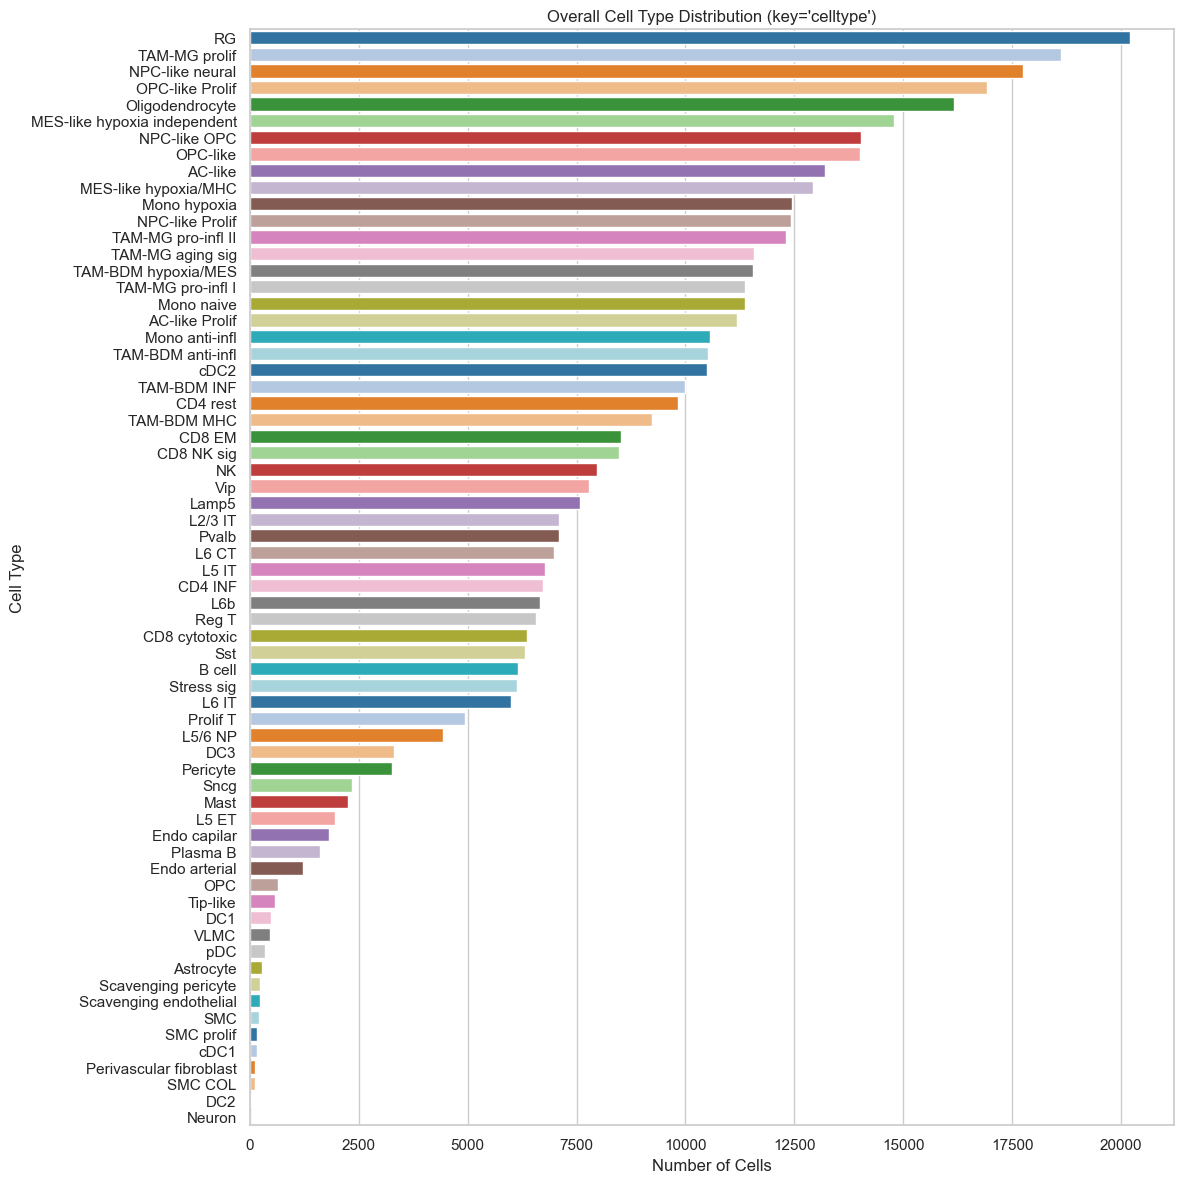

In [46]:
plot_overall_celltype_distribution(tma_data, celltype_key='celltype', plot_type='bar')

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_celltype_per_patient_heatmap(
    TMA_objects,
    celltype_key='celltype',
    sample_label_key='patient_id',
    normalize='none',
    cmap='Reds',
    figsize=(10, 8)
):
    """
    Creates a heatmap showing the distribution of cell types per patient (row=patient, col=celltype).
    This is more ergonomic than a huge stacked bar chart if you have many patients/cell types.

    Parameters
    ----------
    TMA_objects : list[AnnData]
        Each AnnData is a single patient's data (or a single MERFISH sample).
        We expect .obs[celltype_key] labeling cell types for each cell.
        Also, if sample_label_key is provided, we read adata.obs[sample_label_key].iloc[0]
        for the patient's name. Otherwise, we label them as 'Sample_0', 'Sample_1', ...
    celltype_key : str, optional
        Column in .obs that indicates the cell type of each cell (default: 'celltype').
    sample_label_key : str, optional
        If provided, each AnnData must have adata.obs[sample_label_key] to identify the patient name.
        Otherwise, we label them 'Sample_0', 'Sample_1', ...
    normalize : {'none', 'row', 'col'}, optional
        - 'none': Show raw counts (# of cells).
        - 'row': Convert each patient's row to percentages (sums to 1 or 100% across cell types).
        - 'col': Convert each cell-type column to percentages (sums to 1 or 100% down patients).
    cmap : str, optional
        Colormap for the heatmap (default 'Reds').
    figsize : tuple, optional
        Size of the figure (width, height) in inches.
    
    Returns
    -------
    None. Displays a heatmap.
    """
    
    # 1) Accumulate data from each patient (AnnData)
    all_data = []
    for i, adata in enumerate(TMA_objects):
        # Derive patient/sample name
        if sample_label_key and sample_label_key in adata.obs:
            patient_name = str(adata.obs[sample_label_key].iloc[0])
        else:
            patient_name = f"Sample_{i}"
        
        # Check celltype_key presence
        if celltype_key not in adata.obs:
            print(f"Warning: '{celltype_key}' not found in adata.obs for {patient_name}. Skipping.")
            continue
        
        # Extract the celltype array for all cells
        celltype_arr = adata.obs[celltype_key].values
        
        # Build DataFrame with columns: [patient, celltype]
        df_sample = pd.DataFrame({
            'patient': patient_name,
            'celltype': celltype_arr
        })
        all_data.append(df_sample)

    if not all_data:
        print(f"No data found with '{celltype_key}' across TMA_objects. Exiting.")
        return
    
    # 2) Concatenate into one DataFrame
    df_all = pd.concat(all_data, ignore_index=True)

    # 3) Group by (patient, celltype) => count how many cells
    count_df = df_all.groupby(['patient', 'celltype']).size().reset_index(name='count')

    # 4) Pivot => row=patient, col=celltype, values=count
    pivot_df = count_df.pivot(index='patient', columns='celltype', values='count').fillna(0)

    # 5) Normalize if requested
    #    'row' => each row sums to 1, 'col' => each col sums to 1
    if normalize == 'row':
        pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)  # fraction of row
    elif normalize == 'col':
        pivot_df = pivot_df.div(pivot_df.sum(axis=0), axis=1)  # fraction of column
    elif normalize == 'none':
        pass
    else:
        raise ValueError("normalize must be one of {'none','row','col'}.")

    # 6) Plot as heatmap
    plt.figure(figsize=figsize)
    # Convert to float in case it's integer-based
    data_for_heatmap = pivot_df.astype(float).copy()

    # If we did row or col normalization, you might want to multiply by 100 to show percent
    if normalize in ('row','col'):
        data_for_heatmap *= 100
    
    # Seaborn heatmap
    sns.heatmap(
        data_for_heatmap,
        cmap=cmap,
        # If you want to see actual values, set annot=True (but it might get crowded)
        annot=False,
        fmt=".1f"
    )
    
    title_str = f"Cell Type per Patient Heatmap [key='{celltype_key}']"
    if normalize in ('row','col'):
        title_str += " (normalized)"
    plt.title(title_str)
    plt.xlabel("Cell Type")
    plt.ylabel("Patient")
    plt.tight_layout()
    plt.show()


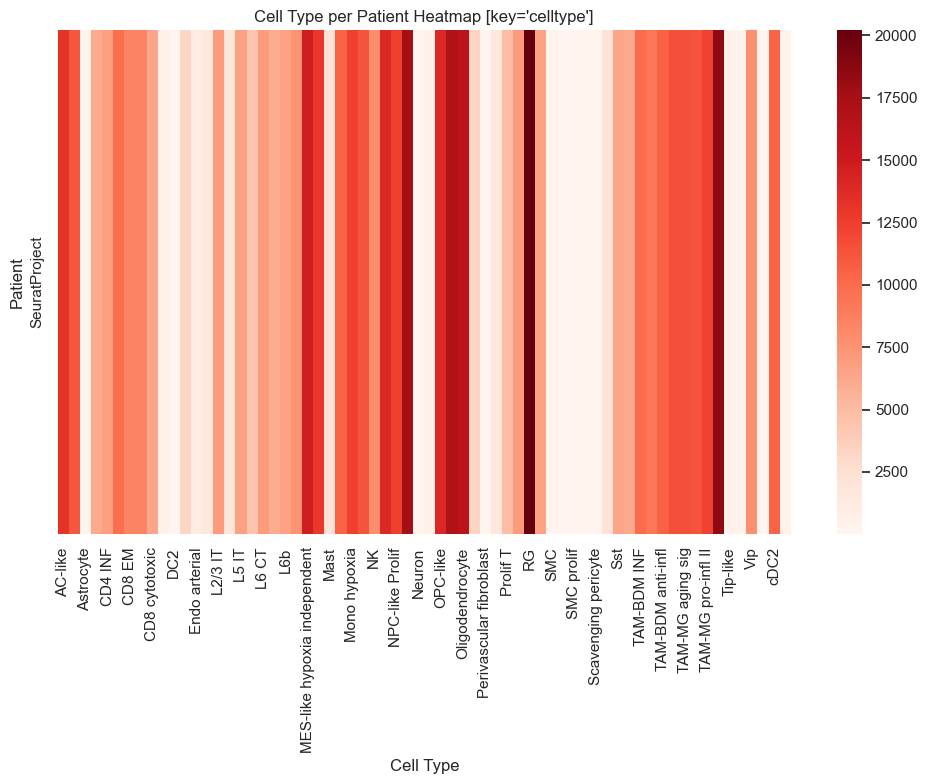

In [50]:
plot_celltype_per_patient_heatmap(tma_data, celltype_key='celltype', sample_label_key='orig.ident')


In [3]:
362425  + 93803 

456228

In [ ]:
# plot batch colored Umap of the concatenated object:


In [7]:
import os
import json
import torch
from tqdm import tqdm
import torch.nn.functional as F


def train_vae_batch(model,
              train_dataloader,
              val_dataloader,
              epochs,
              optimizer,
              model_save_dir,
              device,
              kl_weight=1.0,
              clip_value=1.0,
              early_stopping_patience=20,
              min_delta=0,
              learning_rate_patience=10):
    """
    Train VAE using ZINB negative log likelihood with library-size & batch handling, akin to scVI.

    Args:
        model: VAE_v3 instance
        train_dataloader, val_dataloader: yield (x, batch_idx, library_size) or similar
        epochs: number of epochs
        optimizer: torch optimizer
        model_save_dir: directory to save model checkpoints
        device: 'cpu' or 'cuda'
        kl_weight: weighting factor for KL term
        clip_value: gradient clipping value
        early_stopping_patience, min_delta: parameters for EarlyStopping
        learning_rate_patience: patience for ReduceLROnPlateau
    """

    # Move model to device
    model = model.to(device)

    # Early stopping utility
    early_stopping = EarlyStopping(patience=early_stopping_patience, min_delta=min_delta)
    best_val_loss = float('inf')

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.55, patience=learning_rate_patience
    )

    # Dictionary for training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_zinb': [], 'val_zinb': [],
        'train_kl': [], 'val_kl': [],
        'lr': [], 'best_loss': float('inf')
    }

    os.makedirs(model_save_dir, exist_ok=True)
    best_model_path = os.path.join(model_save_dir, 'best_model.pth')

    for epoch in tqdm(range(epochs), desc='Training'):
        # ====================================================
        # Training Phase
        # ====================================================
        model.train()
        total_train_loss = 0.0
        train_kld = 0.0
        train_zinb = 0.0

        for batch_data in train_dataloader:
            # Expecting batch_data to be (x, batch_idx, library_size)
            # or some variation. Adjust as needed for your data structure:
            if len(batch_data) == 3:
                x, batch_idx, library_size = batch_data
                batch_idx = batch_idx.to(device)
                library_size = library_size.to(device)
                x = x.to(device)
            else:
                return ValueError("Expecting (x, batch_idx, library_size) in train_dataloader")


            mean, logvar, scale, dropout, theta = model(x, batch_idx, library_size)

            # KLD
            kld = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).mean()

            # ZINB Reconstruction Loss
            # scale should already be scaled by library_size if your decoder does that internally.
            # If not, multiply scale by torch.exp(library_size) here (assuming library_size is log of SF).
            zinb_recon_loss = zinb_negative_log_likelihood(x, scale, theta, dropout)

            loss = zinb_recon_loss + kl_weight * kld

            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()

            total_train_loss += loss.item()
            train_kld += kld.item()
            train_zinb += zinb_recon_loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_kld = train_kld / len(train_dataloader)
        avg_train_zinb = train_zinb / len(train_dataloader)

        # ====================================================
        # Validation Phase
        # ====================================================
        model.eval()
        total_val_loss = 0.0
        val_kld = 0.0
        val_zinb = 0.0

        with torch.no_grad():
            for batch_data in val_dataloader:
                if len(batch_data) == 3:
                    x, batch_idx, library_size = batch_data
                    batch_idx = batch_idx.to(device)
                    library_size = library_size.to(device)
                    x = x.to(device)

                else:
                    return ValueError("Expecting (x, batch_idx, library_size) in val_dataloader")


                mean, logvar, scale, dropout, theta = model(x, batch_idx, library_size)

                # KLD
                kld = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).mean()

                # ZINB loss
                zinb_recon_loss = zinb_negative_log_likelihood(x, scale, theta, dropout)

                loss = zinb_recon_loss + kl_weight * kld

                total_val_loss += loss.item()
                val_kld += kld.item()
                val_zinb += zinb_recon_loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_kld = val_kld / len(val_dataloader)
        avg_val_zinb = val_zinb / len(val_dataloader)

        # Update scheduler
        scheduler.step(avg_val_loss)

        # Save history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_zinb'].append(avg_train_zinb)
        history['val_zinb'].append(avg_val_zinb)
        history['train_kl'].append(avg_train_kld)
        history['val_kl'].append(avg_val_kld)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Print progress
        print(f"\nEpoch {epoch + 1}")
        print(f"Train Loss: {avg_train_loss:.4f} (KLD={avg_train_kld:.4f}, ZINB={avg_train_zinb:.4f})")
        print(f"Val Loss: {avg_val_loss:.4f}   (KLD={avg_val_kld:.4f}, ZINB={avg_val_zinb:.4f})")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Checkpoint best model
        early_stopping(avg_val_loss)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            history['best_loss'] = best_val_loss

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
                'history': history
            }, best_model_path)
            print(f'Best model saved to {best_model_path}')

        if early_stopping.early_stop:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            checkpoint = torch.load(best_model_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            break

    # Save final history
    history_path = os.path.join(model_save_dir, 'training_history.json')
    with open(history_path, 'w') as f:
        json.dump(history, f)
    print(f'Training history saved to {history_path}')

    return model, history


In [8]:
# Train the model

n_batches = 74
# have to set it in 74 because , raw batch indices range from 0 up to 73,
# and so there are actually 74 distinct possible index values. since the  indexing is zero-base,
# That means if the maximum index is 73, then the total number of unique indices is 73 + 1, which equals 74.
#so  Setting n_batches to 74  to ensures that all indices from 0 through 73 are valid when used for the embedding layer.
batch_embed_dim = 16

model_vae_3 = VAE_v3(
    input_dim=500,
    latent_dim=20,
    encoder_hidden_dims=[256, 128],
    decoder_hidden_dims=[128, 256],
    dropout_rate=0.1,
    n_batches=n_batches,
    batch_embed_dim=batch_embed_dim
)

optimizer = torch.optim.Adam(model_vae_3.parameters(), lr=1e-4, weight_decay=1e-4)


In [9]:
summary(model_vae_3)

Layer (type:depth-idx)                   Param #
VAE_v3                                   --
├─Encoder: 1-1                           --
│    └─Embedding: 2-1                    1,184
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-1                  132,352
│    │    └─LayerNorm: 3-2               512
│    │    └─ReLU: 3-3                    --
│    │    └─Dropout: 3-4                 --
│    │    └─Linear: 3-5                  32,896
│    │    └─LayerNorm: 3-6               256
│    │    └─ReLU: 3-7                    --
│    │    └─Dropout: 3-8                 --
│    └─Linear: 2-3                       2,580
│    └─Linear: 2-4                       2,580
├─Decoder: 1-2                           500
│    └─Sequential: 2-5                   --
│    │    └─Linear: 3-9                  2,688
│    │    └─LayerNorm: 3-10              256
│    │    └─ReLU: 3-11                   --
│    │    └─Dropout: 3-12                --
│    │    └─Linear: 3-13                 33,02

In [10]:

model, history = train_vae_batch(
    model=model_vae_3,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=50,
    optimizer=optimizer,
    model_save_dir="'/content/drive/MyDrive/LabMembers/Hamid/Eco_Foundation/Eco_Foundation/train_model_notebook/Train_Vae_v3'",
    device=None,
    kl_weight=1.0,
    clip_value=1.0,
    early_stopping_patience=10,
    min_delta=0,
    learning_rate_patience=5
)


Training:   0%|          | 0/50 [01:50<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
plot_curves('/train_model_notebook/Train_Vae_v2/training_files')

In [ ]:
import importlib
#importlib.reload(utils_2)
import utils_2
from utils_2 import *
import os

In [ ]:
trained_model = load_trained_model(model,'/content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v1/Training_files/best_model.pth')
trained_model.training

In [ ]:

def get_z(model, dataloader, device="cpu"):
    """
    Get latent space representation (z) for all cells.

    Parameters:
        model: Trained VAE model.
        dataloader: DataLoader with the dataset to process.
        device: Device to perform computation on (default: "cpu").

    Returns:
        z_array: Numpy array of shape (n_cells, latent_dim).
    """
    model.eval()  # Set model to evaluation mode
    model.to(device)

    z_list = []

    with torch.no_grad():
        for x in dataloader:
            x = x.to(device)
            mean, logvar = model.encoder(x)
            z = model.reparameterize(mean, logvar)  # Use reparameterization trick
            z_list.append(z.cpu().numpy())

    z_array = np.vstack(z_list)  # Combine all batches into one array
    return z_array


def get_gene_expression(model, z_array, device="cpu"):
    """
    Reconstruct gene expression for all cells using the decoder.

    Parameters:
        model: Trained VAE model.
        z_array: Numpy array of latent space (shape: n_cells x latent_dim).
        device: Device to perform computation on (default: "cpu").

    Returns:
        gene_expression_array: Numpy array of shape (n_cells, n_genes).
    """
    model.eval()  # Set model to evaluation mode
    model.to(device)

    z_tensor = torch.tensor(z_array, dtype=torch.float32).to(device)  # Convert z_array to tensor
    gene_expression_list = []

    with torch.no_grad():
        for z in z_tensor.split(64):  # Process in batches of 64 to avoid memory issues
            scale, _, _ = model.decoder(z)  # Only use the scale (mean gene expression)
            gene_expression_list.append(scale.cpu().numpy())

    gene_expression_array = np.vstack(gene_expression_list)  # Combine all batches into one array
    return gene_expression_array

In [ ]:
adata = tma_objects[1].copy()
adata


AnnData object with n_obs × n_vars = 10323 × 500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ident', 'celltype', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Graph_DF', 'barcode_mapping', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'pca', 'spatial', 'umap'
    varm: 'PCs'
    layers: 'counts', 'norm'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [ ]:
counts =  adata.layers["counts"].toarray()
counts_tensor = torch.tensor(counts, dtype=torch.float32)
dataset = GeneExpressionDataset(counts_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Latent space shape: (10323, 50)
Reconstructed gene expression shape: (10323, 500)


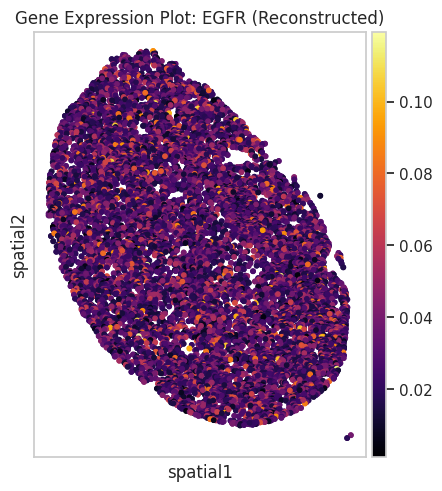

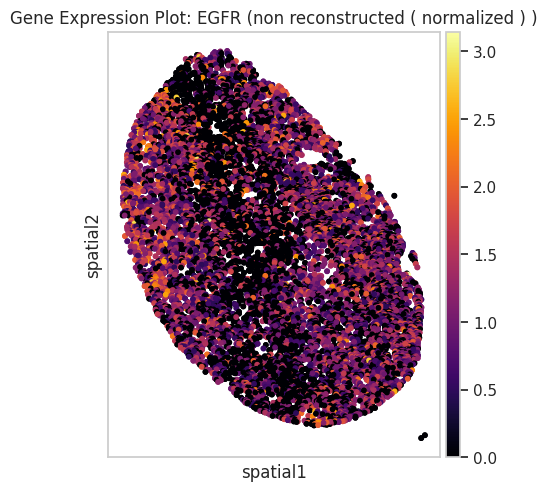

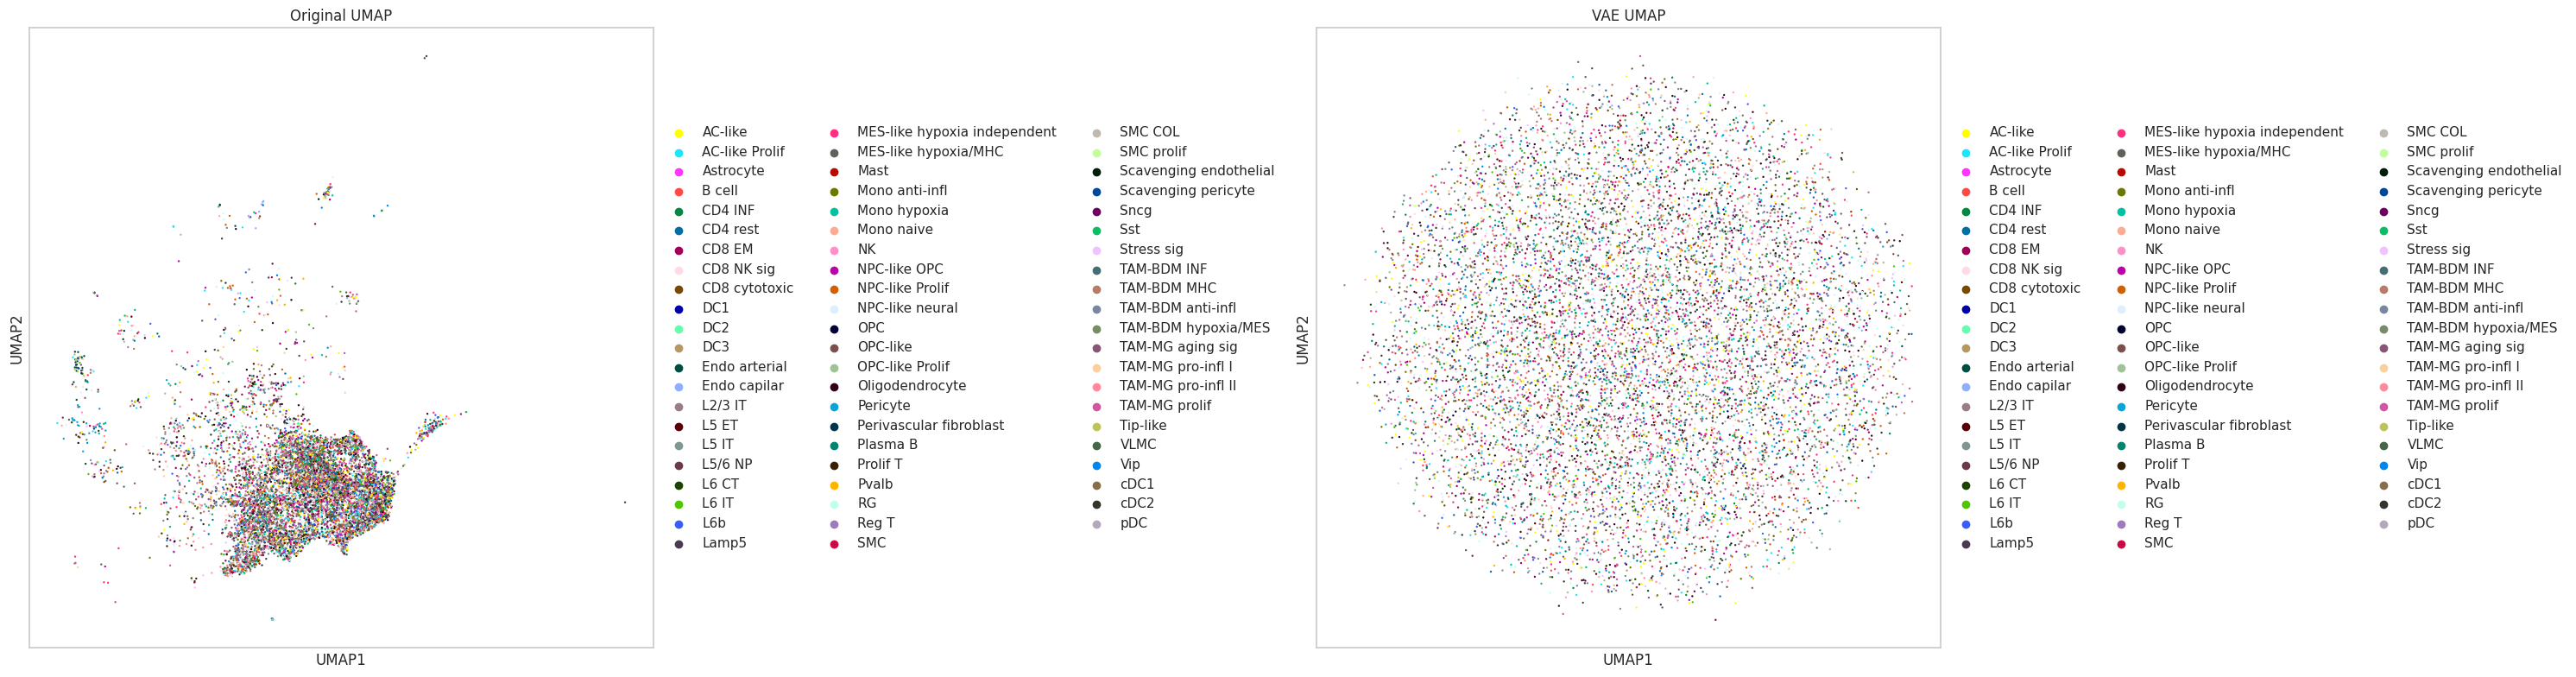

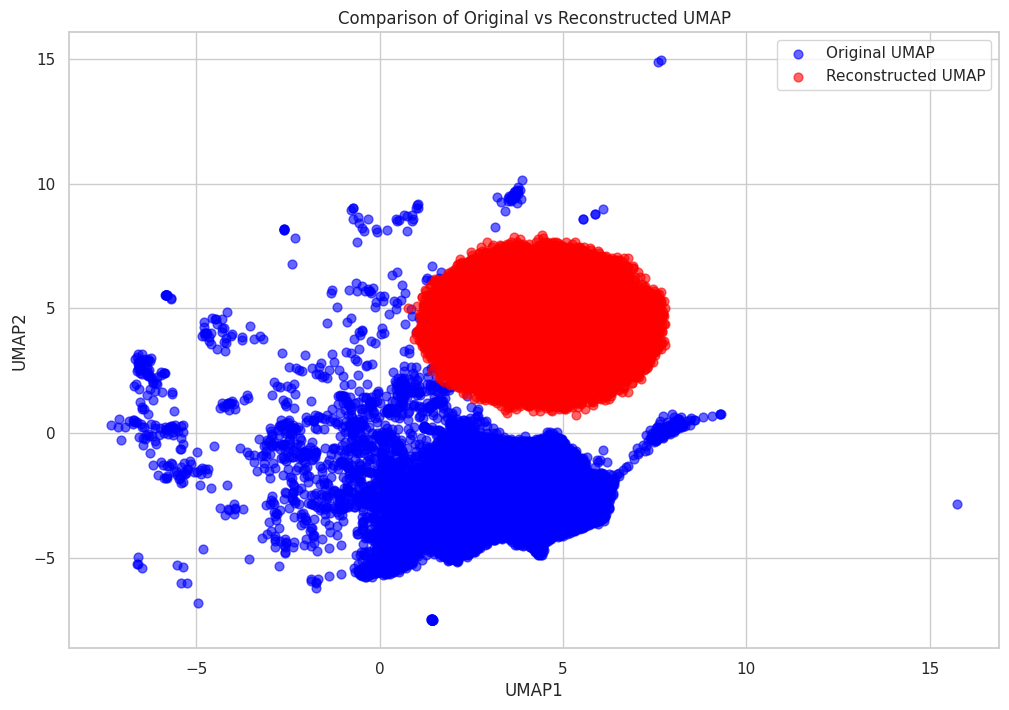


UMAP coordinate correlations:
UMAP1: r=-0.0040 (p=6.8713e-01)
UMAP2: r=-0.0082 (p=4.0532e-01)


In [ ]:

def compare_umap_real_vs_reconstructed(trained_model, dataloader, adata, gene="EGFR", device="cpu"):
    """
    Compare Real UMAP with Reconstructed UMAP (VAE Latent Space).
    """
    # Step 1: Get latent space and reconstructions
    Z = get_z(trained_model, dataloader, device=device)
    print("Latent space shape:", Z.shape)
    recon = get_gene_expression(trained_model, Z, device=device)
    print("Reconstructed gene expression shape:", recon.shape)

    # Step 2: Create a copy for UMAP visualization
    adata_vae = adata.copy()

    # Step 3: Store results
    adata_vae.obsm["VAE_latent"] = Z
    adata_vae.layers["X_VAE"] = recon

    # Step 4: Plot Gene Expression if specified
    if gene is not None:
        adata_exp = adata.copy()
        adata_exp.X = recon  # Use reconstructed data
        sns.set(style="whitegrid")
        sq.pl.spatial_scatter(adata_exp,
                            shape=None,
                            color=[gene],
                            size=40,
                            cmap="inferno")
        plt.title(f"Gene Expression Plot: {gene} (Reconstructed)")
        plt.show()

        adata.X = adata.layers["norm"]  # Use original data
        sns.set(style="whitegrid")
        sq.pl.spatial_scatter(adata,
                            shape=None,
                            color=[gene],
                            size=40,
                            cmap="inferno")
        plt.title(f"Gene Expression Plot: {gene} (non reconstructed ( normalized ) )")
        plt.show()


    # Step 5: Get original UMAP (prioritize 'umap' slot)
    original_umap = adata.obsm['umap'].copy()

    # Step 6: Compute new UMAP from latent space
    sc.pp.neighbors(adata_vae, use_rep="VAE_latent")
    sc.tl.umap(adata_vae)
    reconstructed_umap = adata_vae.obsm['X_umap'].copy()

    # Step 7: Plot UMAPs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 8))

    # Plot original
    adata_vae.obsm['umap'] = original_umap
    sc.pl.umap(adata_vae,
               color=['celltype'],
               ax=ax1,
               show=False,
               title='Original UMAP')

    # Plot reconstructed
    adata_vae.obsm['umap'] = reconstructed_umap
    sc.pl.umap(adata_vae,
               color=['celltype'],
               ax=ax2,
               show=False,
               title='VAE UMAP')

    plt.tight_layout()
    plt.show()

    # Step 8: Plot comparison overlay
    plt.figure(figsize=(12, 8))
    plt.scatter(original_umap[:, 0], original_umap[:, 1],
               c='blue', label='Original UMAP', alpha=0.6, s=40)
    plt.scatter(reconstructed_umap[:, 0], reconstructed_umap[:, 1],
               c='red', label='Reconstructed UMAP', alpha=0.6, s=40)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('Comparison of Original vs Reconstructed UMAP')
    plt.legend()
    plt.show()

    # Print correlations
    corr_umap1, p1 = pearsonr(original_umap[:, 0], reconstructed_umap[:, 0])
    corr_umap2, p2 = pearsonr(original_umap[:, 1], reconstructed_umap[:, 1])
    print(f"\nUMAP coordinate correlations:")
    print(f"UMAP1: r={corr_umap1:.4f} (p={p1:.4e})")
    print(f"UMAP2: r={corr_umap2:.4f} (p={p2:.4e})")

    return original_umap, reconstructed_umap



original, reconstructed = compare_umap_real_vs_reconstructed(
    trained_model=trained_model,
    dataloader=dataloader,
    adata=adata,
    device="cuda"
)

In [ ]:
adata

AnnData object with n_obs × n_vars = 10323 × 500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ident', 'celltype', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Graph_DF', 'barcode_mapping', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'pca', 'spatial', 'umap'
    varm: 'PCs'
    layers: 'counts', 'norm'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [ ]:
## add library size normalization for VAE

import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import NegativeBinomial
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

####################################################
# 1) A custom Dataset that stores counts + scale_factors
####################################################

class GeneExpressionDatasetSF(Dataset):
    """
    Stores raw count data and a library-size scale factor
    for each cell. Returns (counts_row, scale_factor_row).
    """
    def __init__(self, counts, scale_factors):
        """
        counts:       (N, G) array of raw counts (N = total cells, G = #genes)
        scale_factors (N,)   array of per-cell library scale factors
        """
        super().__init__()
        self.counts = torch.tensor(counts, dtype=torch.float32)
        self.sf = torch.tensor(scale_factors, dtype=torch.float32)

    def __len__(self):
        return self.counts.shape[0]

    def __getitem__(self, idx):
        return self.counts[idx], self.sf[idx]



def split_data_by_cells_with_sf(
    TMA_objects,
    data_type='counts',
    val_ratio=0.2,
    seed=42,
    target_lib_size=1e4
):
    """
    Splits TMA objects (AnnData) at the sample level into
    train/validation sets while targeting ~ val_ratio of total cells,
    and computes library-size scale factors for each cell.

    Parameters
    ----------
    TMA_objects : list of AnnData
        Each AnnData is treated as a single 'sample.'
    data_type : str
        Key in adata.layers to extract the raw counts (default 'counts').
    val_ratio : float
        Fraction of total cells to aim for in validation set.
    seed : int
        Random seed for reproducibility.
    target_lib_size : float
        The library size to which each cell is scaled (e.g., 1e4).

    Returns
    -------
    train_dataset : GeneExpressionDatasetSF
    val_dataset   : GeneExpressionDatasetSF
    """

    torch.manual_seed(seed)

    sample_counts = []
    sample_sfs = []
    cells_per_sample = []

    # 1) Gather data from each sample
    for adata in TMA_objects:
        # Extract raw counts as a 2D NumPy array
        if hasattr(adata.layers[data_type], "A"):
            counts_arr = adata.layers[data_type].A  # sparse .A
        else:
            counts_arr = adata.layers[data_type].toarray()

        n_cells = counts_arr.shape[0]

        # Library size from adata.obs (per cell)
        lib_size = adata.obs["nCount_RNA"].values  # shape = (n_cells,)
        # Per-cell scale factor
        sf = target_lib_size / (lib_size + 1e-8)

        sample_counts.append(counts_arr)
        sample_sfs.append(sf)
        cells_per_sample.append(n_cells)

    total_cells = sum(cells_per_sample)
    target_val_cells = int(val_ratio * total_cells)

    # 2) Shuffle the sample indices
    indices = torch.randperm(len(sample_counts))

    # 3) Accumulate entire samples for val set until we reach ~ val_ratio
    current_val_cells = 0
    split_idx = 0
    for i in indices:
        current_val_cells += cells_per_sample[i]
        split_idx += 1
        if current_val_cells >= target_val_cells:
            break

    val_indices = indices[:split_idx]
    train_indices = indices[split_idx:]

    # 4) Stack train samples
    train_counts_list = []
    train_sf_list     = []
    for i in train_indices:
        train_counts_list.append(sample_counts[i])
        train_sf_list.append(sample_sfs[i])
    train_data = np.vstack(train_counts_list)  # shape = (N_train, G)
    train_sf   = np.concatenate(train_sf_list) # shape = (N_train,)

    # 5) Stack val samples
    val_counts_list = []
    val_sf_list     = []
    for i in val_indices:
        val_counts_list.append(sample_counts[i])
        val_sf_list.append(sample_sfs[i])
    val_data = np.vstack(val_counts_list)      # shape = (N_val, G)
    val_sf   = np.concatenate(val_sf_list)     # shape = (N_val,)

    print("\nSplit results:")
    print(f"  Training: {len(train_indices)} samples, {train_data.shape[0]} cells "
          f"({train_data.shape[0]/total_cells*100:.1f}%)")
    print(f"  Validation: {len(val_indices)} samples, {val_data.shape[0]} cells "
          f"({val_data.shape[0]/total_cells*100:.1f}%)")

    # 6) Create PyTorch datasets
    train_dataset = GeneExpressionDatasetSF(train_data, train_sf)
    val_dataset   = GeneExpressionDatasetSF(val_data,   val_sf)

    return train_dataset, val_dataset



In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims=[256, 128], dropout_rate=0.1):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for hdim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hdim))
            layers.append(nn.BatchNorm1d(hdim))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            prev_dim = hdim

        self.net = nn.Sequential(*layers)
        self.mean_layer   = nn.Linear(prev_dim, latent_dim)
        self.logvar_layer = nn.Linear(prev_dim, latent_dim)

    def forward(self, x):
        h = self.net(x)
        mean = self.mean_layer(h)
        logvar = self.logvar_layer(h)
        return mean, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, hidden_dims=[128,256], dropout_rate=0.1):
        super().__init__()
        layers = []
        prev_dim = latent_dim
        for hdim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hdim))
            layers.append(nn.BatchNorm1d(hdim))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            prev_dim = hdim

        self.net = nn.Sequential(*layers)
        self.scale_layer   = nn.Linear(prev_dim, output_dim)  # predicted mean
        self.dropout_layer = nn.Linear(prev_dim, output_dim)  # zero-inflation
        self.log_theta     = nn.Parameter(torch.zeros(1, output_dim))  # dispersion

    def forward(self, z):
        h = self.net(z)
        scale   = F.relu(self.scale_layer(h)) + 1e-8
        dropout = torch.sigmoid(self.dropout_layer(h))
        theta   = torch.exp(self.log_theta)
        return scale, dropout, theta


class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=20,
                 encoder_hidden_dims=[256,128],
                 decoder_hidden_dims=[128,256],
                 dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim, encoder_hidden_dims, dropout_rate)
        self.decoder = Decoder(latent_dim, input_dim, decoder_hidden_dims, dropout_rate)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        scale, dropout, theta = self.decoder(z)
        return mean, logvar, scale, dropout, theta


In [ ]:
def zinb_loss_with_sf(x, scale, dropout, theta, sf, eps=1e-8):
    """
    'Approach 1' for library-size correction: multiply scale by sf[i] for each cell.
    x:       (batch_size, n_genes) raw counts
    scale:   (batch_size, n_genes) base mean from decoder
    dropout: (batch_size, n_genes) zero-inflation probability
    theta:   (1, n_genes) or (batch_size, n_genes) dispersion
    sf:      (batch_size,) scale factors for each cell
    """
    # Multiply predicted mean by scale_factors
    scale = scale * sf.unsqueeze(1)  # shape = (batch_size, n_genes)

    # Standard ZINB
    theta = torch.clamp(theta, min=eps)
    scale = torch.clamp(scale, min=eps)

    nb_prob = theta / (theta + scale)
    nb_prob = torch.clamp(nb_prob, min=1e-6, max=1-1e-6)

    log_nb = NegativeBinomial(total_count=theta, probs=nb_prob).log_prob(x)
    zero_inflation = torch.log(dropout + (1 - dropout)*torch.exp(log_nb) + eps)

    zinb_ll = torch.where(
        x < eps,  # effectively x==0 if integer
        zero_inflation,
        log_nb + torch.log(1 - dropout + eps)
    )

    return -zinb_ll.sum(dim=1).mean()


In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

def train_vae_scale_factor(
    model,
    train_loader,
    val_loader,
    epochs,
    optimizer,
    save_dir="./ckpt_scale_factor",
    device="cuda",
    kl_weight=1.0,
    patience=5
):
    os.makedirs(save_dir, exist_ok=True)
    best_path = os.path.join(save_dir, "best_model.pth")

    stopper = EarlyStopping(patience=patience)
    best_val_loss = float("inf")

    history = {
        "train_loss": [], "val_loss": [],
        "train_zinb": [], "val_zinb": [],
        "train_kl": [],   "val_kl": []
    }

    model.to(device)

    for epoch in range(epochs):
        # --- Train ---
        model.train()
        train_loss_sum, train_zinb_sum, train_kl_sum = 0, 0, 0

        for x, sf in train_loader:
            x, sf = x.to(device), sf.to(device)
            optimizer.zero_grad()

            mean, logvar, scale, dropout, theta = model(x)
            kl = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).mean()
            zinb_recon = zinb_loss_with_sf(x, scale, dropout, theta, sf)

            loss = zinb_recon + kl_weight * kl
            loss.backward()
            optimizer.step()

            train_loss_sum  += loss.item()
            train_zinb_sum  += zinb_recon.item()
            train_kl_sum    += kl.item()

        n_train = len(train_loader)
        avg_train_loss = train_loss_sum / n_train
        avg_train_zinb = train_zinb_sum / n_train
        avg_train_kl   = train_kl_sum   / n_train

        # --- Validation ---
        model.eval()
        val_loss_sum, val_zinb_sum, val_kl_sum = 0, 0, 0

        with torch.no_grad():
            for x, sf in val_loader:
                x, sf = x.to(device), sf.to(device)
                mean, logvar, scale, dropout, theta = model(x)
                kl = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).mean()
                zinb_recon = zinb_loss_with_sf(x, scale, dropout, theta, sf)

                val_batch_loss = zinb_recon + kl_weight * kl
                val_loss_sum  += val_batch_loss.item()
                val_zinb_sum  += zinb_recon.item()
                val_kl_sum    += kl.item()

        n_val = len(val_loader)
        avg_val_loss = val_loss_sum / n_val
        avg_val_zinb = val_zinb_sum / n_val
        avg_val_kl   = val_kl_sum   / n_val

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_zinb"].append(avg_train_zinb)
        history["val_zinb"].append(avg_val_zinb)
        history["train_kl"].append(avg_train_kl)
        history["val_kl"].append(avg_val_kl)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train: loss={avg_train_loss:.4f} (ZINB={avg_train_zinb:.4f}, KL={avg_train_kl:.4f})")
        print(f"  Val:   loss={avg_val_loss:.4f}   (ZINB={avg_val_zinb:.4f}, KL={avg_val_kl:.4f})")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_path)

        stopper(avg_val_loss)
        if stopper.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # load best
    model.load_state_dict(torch.load(best_path))

    # Save history
    hist_path = os.path.join(save_dir, "training_history.json")
    with open(hist_path, "w") as f:
        json.dump(history, f)

    print("Training complete. Best model loaded. History saved.")
    return model, history


In [ ]:
 # 1) Split into train/val at the sample level, computing scale factors
    train_dataset, val_dataset = split_data_by_cells_with_sf(
        TMA_objects,
        data_type='counts',
        val_ratio=0.2,
        seed=42,
        target_lib_size=1e4
    )

    # 2) Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=128, shuffle=False)

    # 3) Setup VAE
    n_genes = train_dataset.counts.shape[1]
    model = VAE(
        input_dim=n_genes,
        latent_dim=20,
        encoder_hidden_dims=[256,128],
        decoder_hidden_dims=[128,256],
        dropout_rate=0.1
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 4) Train
    trained_model, history = train_vae_scale_factor(
        model,
        train_loader,
        val_loader,
        epochs=50,
        optimizer=optimizer,
        save_dir="content/drive/MyDrive/LabMembers/Hamid/EcoFoundation_Hamid/train_model/Train_Vae_v2/Training_files/scale_factor_approach",
        device=device,
        kl_weight=1.0,
        patience=5
    )

